<a href="https://colab.research.google.com/github/andrewcfreeman/SimpleHashCodes/blob/main/hash_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import string
from typing import Type, TypeVar
import sys
import numpy as np
from sortedcontainers import SortedList  # For the "storing elsewhere" approach to collision resolution


def str_to_class(classname):
    """
    https://stackoverflow.com/questions/1176136/convert-string-to-python-class-object

    Trying to force Python into a semi-functional style
    """
    return getattr(sys.modules[__name__], classname)


class Coder:
    """https://stackoverflow.com/questions/55751368/python-how-to-pass-to-a-function-argument-type-of-a-class-object
    -typing """

    T = 0
    table = []
    collision_res_type = ''
    buckets = []

    def __init__(self):
        print("Creating a %s" % self.__class__.__name__)

    def init_buckets(self):
        if self.collision_res_type == 'store':
            self.buckets = np.empty(self.T, dtype=SortedList)

    def insert(self, h, s, x):
        if self.table[h] is None:
            self.table[h] = s
        else:
            self.resolve_collision(h, s, x)

    def resolve_collision(self, h, s, x):
        if self.collision_res_type == 'append':
            self.resolve_append(h, s)
        elif self.collision_res_type == 'store':
            self.resolve_store(h, s, x)
        else:
            print("Bad value for collision resolution type")

    def resolve_append(self, h, s):
        for i in range(self.T):
            if self.table[(i + h) % self.T] is None:
                self.table[(i + h) % self.T] = s
                return
        print("Could not resolve collision for hash ", h)

    def resolve_store(self, h, s, x):
        if self.table[h] >= 0:
            # Then we need to create new bucket
            self.buckets[h] = SortedList()
            self.buckets[h].update([x[self.table[h]], x[s]])
            self.table[h] = -h
        else:
            self.buckets[h].update([x[s]])

    def lookup(self, h, xs):
        if self.table[h] is None:
            return False, []
        else:
            s = self.table[h]
            if s < 0:  # Then the resolution type is 'store' and it's in a bucket
                bucket = self.buckets[-s]
                if xs in bucket:
                    return True, []
                else:
                    return False, []
            else:
                return True, s
            # if xs == x

TCoder = TypeVar("TCoder", bound=Coder)


class Div(Coder):

    def __init__(self, collision_res_type):
        self.T = 37  # Prime number, preferably far from power of 2
        self.table = np.full(self.T, None)  # Initialize table with None
        self.collision_res_type = collision_res_type
        self.init_buckets()

    def hash(self, x) -> None:
        # If a string is input, convert it to an int
        if isinstance(x, str):
            charsum = 0
            for character in range(0, len(x)):
                charsum += ord(x[character])
            x = charsum
        return x % self.T


class Var_string(Coder):

    def __init__(self, collision_res_type):
        self.T = 256
        self.table = np.full(self.T, None)  # Initialize table with None
        self.collision_res_type = collision_res_type
        self.init_buckets()

    def hash(self, x) -> None:
        if isinstance(x, str):
            sum = 0
            for i in range(len(x)):
                sum = (sum + ord(x[i])) % 256
            return sum


class Var_string_xor(Coder):
    rand8 = np.random.permutation(range(0, 256))

    def __init__(self, collision_res_type):
        self.T = 65536
        self.table = np.full(self.T, None)  # Initialize table with None
        self.collision_res_type = collision_res_type
        self.init_buckets()

    def hash(self, x) -> None:
        if isinstance(x, str):
            sum1 = ord(x[0])
            sum2 = ord(x[1])
            for i in range(1, len(x)):
                sum1 = self.rand8[sum1 ^ ord(x[i])]
                sum2 = self.rand8[sum2 ^ ord(x[i])]

            return (sum1 << 8) | sum2


def resolve_collision(v: Coder, h, s) -> None:
    v.resolve_collision(h, s)


def instantiate(class_to_instantiate: Type[TCoder], collision_res_type) -> TCoder:
    return class_to_instantiate(collision_res_type)  # create an instance


# Note use of zero-indexing throughout, unlike the textbook

# **Div hashing with 'append' collision handling**

---



In [ ]:
x_size = 40
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Div'), 'append')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1])
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")

Could not resolve collision for hash  12
Could not resolve collision for hash  32
Could not resolve collision for hash  12
Found record  TULZ  with data  JCOSXDDVHN


# **Div hashing with 'store elsewhere' collision handling**

---



In [ ]:
x_size = 200
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Div'), 'store')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

# h = coder.hash(x[1])
h = coder.hash("[fji")
found, loc = coder.lookup(h, x[1])
if found:
    print("Found record")
else:
    print("Record not found")

Record not found


# **var_string hashing with 'append' collision handling**

---



In [ ]:
x_size = 260
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string'), 'append')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1])
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")

Could not resolve collision for hash  81
Could not resolve collision for hash  25
Could not resolve collision for hash  41
Could not resolve collision for hash  48
Found record  ETXC  with data  VONWWYEZNV


# **var_string hashing with 'store elsewhere' collision handling**

---



In [ ]:
x_size = 10000
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string'), 'store')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

# h = coder.hash(x[1])
h = coder.hash("[fji")

found, __ = coder.lookup(h, x[1])
if found:
    print("Found record")
else:
    print("Record not found")

Record not found


# **var_string_xor hashing with 'append' collision handling**

---



In [ ]:
x_size = 65540 # Need 16-bit hashes, so this much data will ensure some collisions
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string_xor'), 'append')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1])
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")


Could not resolve collision for hash  28526
Could not resolve collision for hash  37592
Could not resolve collision for hash  476
Could not resolve collision for hash  7844
Found record  UINT  with data  TGRWKLXKLW


# **var_string_xor hashing with 'store elsewhere' collision handling**

---




In [ ]:
x_size = 100000
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=5))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string_xor'), 'store')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1])
if found:
    print("Found record")
else:
    print("Record not found")


Found record


# **Just for fun: detect different regions in an edited image with hashing**

---



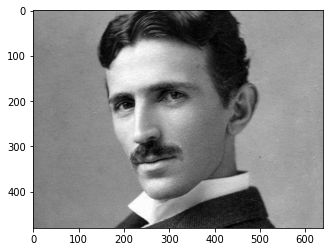

Hash 1:  MAMRVNXRPJTBHSXHYOENAGEWUOPWMDIRYQPCERATSIYLUBVG


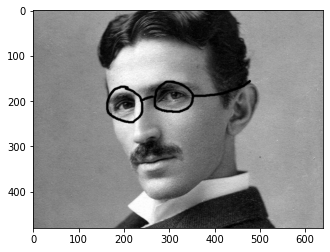

Hash 2:  MAMRVNXRPJTKHGIHYOAPNVEWUOUWMDIRYQPCERATSIYLUBVG


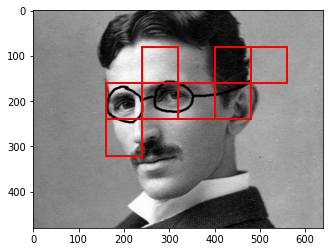

In [11]:
from PIL import Image
from matplotlib import pyplot as plt
import requests
from io import BytesIO
import numpy as np


block_size = 80     # Unconventional block size but for simplicity with this example
def hash_image(image):
    w = image.shape[1]   # image height
    h = image.shape[0]   # image width
    hash = ''
    for i in range(int(h / block_size)):
        for j in range(int(w / block_size)):
            block = image[i * block_size: (i+1) * block_size, j * block_size: (j+1) * block_size]
            block_hash = chr(int(np.sum(block) % 26 + 65))
            hash = hash + block_hash
    return hash
url = 'https://github.com/andrewcfreeman/SimpleHashCodes/blob/main/tesla.png?raw=true'
image = np.array(Image.open(requests.get(url, stream=True).raw))
plt.imshow(image)
plt.show()
hash = hash_image(image)
print("Hash 1: ", hash)

url = 'https://github.com/andrewcfreeman/SimpleHashCodes/blob/main/tesla_glasses.png?raw=true'
image2 = np.array(Image.open(requests.get(url, stream=True).raw))
plt.imshow(image2)
plt.show()
hash2 = hash_image(image2)
print("Hash 2: ", hash2)

# Visualize the patches with different hashes
w = image.shape[1]   # image height
h = image.shape[0]   # image width
plt.imshow(image2)
fig = plt.gcf()
ax = fig.gca()
for i in range(int(h / block_size)):
    for j in range(int(w / block_size)):
        if hash[i * int(w / block_size) + j] != hash2[i * int(w / block_size) + j]:
            square = plt.Rectangle((j*block_size, i*block_size), block_size,block_size, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(square)

plt.show()

